# Initial Design

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from summit.data import solvent_ds, ucb_ds, DataSet
from summit.domain import Domain, DescriptorsVariable
from summit.initial_design import LatinDesigner

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

## 1. Merge datasets

The relative solubilties (log<sub>10</sub> mole fraction) of potassium hydroxide in the solvents in the database were calculated using COSMO-RS and are provided in [solubilities.csv](solubilities.csv). These solubilites now need to be integrated into the database.

Additionally, Paul Deutsche from UCB pharma has given us a subset of pharmaceutically relevant solvents that we will use for the optimization.

In [6]:
solvent_ds.head(5)

,stenutz_name,cosmo_name,chemical_formula,molecular_weight,density,molar_volume,refractive_index,molecular_refractive_power,dielectric_constant,dipole_moment,...,boiling_point,viscosity,partition_coefficient,vapour_pressure,henry_constant,sigma_1,sigma_2,sigma_3,sigma_4,sigma_5
cas_number,,,,,,,,,,,,,,,,,,,,,
98-07-7,(trichloromethyl)benzene,(trichloromethyl)-benzene,C7H5Cl3,195,1.173,166.6,1.557,53.67,6.9,2.14,...,220,1.85,3.68,0.2,2015.87,0.2054,18.7984,0,0,3.2973
111-78-4,"(1Z,5Z)-cycloocta-1,5-diene","1,5-cyclooctadiene",C8H12,108,0.88,122.9,1.493,35.73,2.38,0.17,...,148,1,2.98,8.87,1884.53,0,15.2165,0.4711,0,0.9742
5194-51-4,"(2E,4E)-2,4-hexadiene","trans,trans-2,4-hexadiene",C6H10,82,0.727,112.9,1.456,30.7,2.22,0.36,...,79,0.37,3.05,225.18,2089.16,0,14.9023,0.0451,0,1.3634
98-87-3,(dichloromethyl)benzene,(dichloromethyl)-benzene,C7H6Cl2,161,1.25,128.8,1.55,41.04,6.9,2.05,...,205,1.99,2.94,0.24,2235.31,0.8684,16.7703,0,0.0081,3.8876
2004-70-8,"(E)-1,3-pentadiene",1-trans-3-pentadiene,C5H8,68,0.683,99.7,1.43,25.77,2.32,0.68,...,42,0.3,2.47,702.08,2326.13,0,12.8734,0.0397,0,1.8346


In [7]:
#Read in solubility data
solubilities = pd.read_csv('solubilities.csv')
solubilities = solubilities.set_index('cas_number')
solubilities = DataSet.from_df(solubilities)
solubilities.head(5)

,solubility
cas_number,
98-07-7,-5.348250
111-78-4,-6.310797
5194-51-4,-6.592425
98-87-3,-0.808447
2004-70-8,-6.135296


In [8]:
ucb_ds.head(5)

,solvent_class,solvent_name
cas_number,,
76-05-1,Acid,Trifluoroacetic acid (TFA)
108-24-7,Acid,Acetic anhydride (Ac2O)
1493-13-6,Acid,Triflic acid
50-21-5,Acid,Lactic Acid
64-18-6,Acid,Formic acid


In [9]:
#Merge data sets
solvent_ds_full = solvent_ds.join(solubilities)
solvent_ds_final = pd.merge(solvent_ds_full, ucb_ds, left_index=True,right_index=True)
print(f"{solvent_ds_final.shape[0]} solvents for optimization")
solvent_ds_final.head(5) #Show first 5 rows of dataset

80 solvents for optimization


,stenutz_name,cosmo_name,chemical_formula,molecular_weight,density,molar_volume,refractive_index,molecular_refractive_power,dielectric_constant,dipole_moment,...,vapour_pressure,henry_constant,sigma_1,sigma_2,sigma_3,sigma_4,sigma_5,solubility,solvent_class,solvent_name
cas_number,,,,,,,,,,,,,,,,,,,,,
56-81-5,"1,2,3-propanetriol",glycerol,C3H8O3,92,1.26,73.1,1.475,20.56,47,2.56,...,0.01,3779.8,1.392,8.3081,2.465,0.5226,3.8766,0.000000,Alcohol,Glycerol
107-06-2,"1,2-dichloroethane","1,2-dichloroethane",C2H4Cl2,99,1.253,79,1.445,21.01,10.36,1.83,...,222.09,2904.4,1.2021,10.4996,0,0,3.5413,-2.004364,Halogenated,"1,2-Dichloroethane (DCE)"
110-71-4,"1,2-dimethoxyethane","1,2-dimethoxyethane",C4H10O2,90,0.869,103.7,1.38,24,7.2,1.71,...,83.42,2260.69,0,12.4399,1.8467,0,1.8566,-2.891152,Ether,Dimethoxyethane (DME)
57-55-6,"1,2-propanediol",propyleneglycol,C3H8O2,76,1.036,73.4,1.431,19.01,32,2.27,...,0.22,1564.35,1.1692,8.5231,1.9315,0.5211,2.2691,0.000000,Alcohol,"1,2-Propanediol"
7226-23-5,"1,3-dimethyltetrahydropyrimidin-2(1H)-one","1,3-dimethyltetrahydropyrimidin-2(1h)-one",C6H12N2O,128,1.064,120.5,1.488,34.71,36.12,4.17,...,0.16,5535.65,0,14.9718,1.6577,0,2.1763,-1.716153,Dipolar aprotic,Dimethyl phosphonyl urea (DMPU)


In [10]:
#Double check that there are no NaNs in the descriptors
values = solvent_ds_final.descriptors_to_numpy()
values = values.astype(np.float64)
check = np.isnan(values)
np.where(check==True)

(array([], dtype=int64), array([], dtype=int64))

## 2. Design Space

We now need to setup the design space, which is just the descriptors for the solvents.

In [11]:
domain = None
domain = Domain()
domain += DescriptorsVariable(name='solvent',
                             description='solvent for the borrowing hydrogen reaction',
                             ds=solvent_ds_final)
domain

Name,Type,Description,Values
solvent,descriptors,solvent for the borrowing hydrogen reaction,80 examples of 19 descriptors


## 3. Initial Design - First Attempt
I'm just going to run an latin hypercube design with the full descriptor set and see what happens.

In [29]:
rs = np.random.RandomState(1) #seed the random number generator for a determinsitic result
lhs = LatinDesigner(domain, random_state=rs)
experiments = lhs.generate_experiments(10)
indices = experiments.get_indices('solvent')[:,0]
solvent_ds_final.iloc[indices, :][solvent_ds_final.metadata_columns]

,stenutz_name,cosmo_name,chemical_formula,solvent_class,solvent_name
cas_number,,,,,
127-19-5,"N,N-dimethylacetamide","n,n-dimethylacetamide",C4H9NO,Dipolar aprotic,Dimethyl acetamide (DMAc)
60-29-7,diethyl ether,diethylether,C4H10O,Ether,Diethyl ether
64-18-6,formic acid,formicacid,CH2O2,Acid,Formic acid
123-25-1,diethyl butanedioate,ethylsuccinate,C8H14O4,Ether,Dimetyl succinate
121-44-8,triethylamine,triethylamine,C6H15N,Base,Triethylamine
109-66-0,pentane,pentane,C5H12,Alkane,Pentane
102-76-1,triacetin,glycerol-triacetate,C9H14O6,Ester,Glycol triacetate
100-51-6,benzyl alcohol,benzylalcohol,C7H8O,Alcohol,Benzyl Alcohol
123-25-1,diethyl butanedioate,ethylsuccinate,C8H14O4,Ether,Dimetyl succinate


To visualize the coverage of the design, I am going to plot the solvent descriptors along the first two principal components.

In [32]:
#Calculate principal components
num_components = 2
pc = PCA(n_components=num_components)
pc.fit(solvent_ds_full.standardize())
pcs = pc.transform(solvent_ds_final.standardize())
print(f"{round(pc.explained_variance_ratio_.sum()*100)}% of variance is explained by {num_components} principal components")

51.0% of variance is explained by 2 principal components


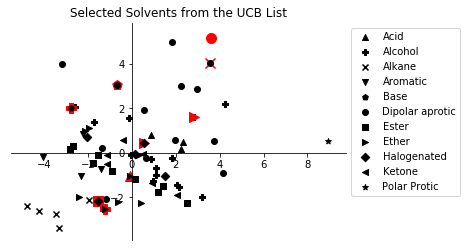

In [33]:
#Display by solvent class on a PCA plot

le = LabelEncoder() #Label encoder for the different solvent classes
solvent_classes = solvent_ds_final['solvent_class']
labels = le.fit_transform(solvent_classes)
fig, ax = plt.subplots()

markers = ['^', 'P', 'x', 'v', 'p', 'o', 's', '>', 'D', '<', '*']
for i, solvent_class in enumerate(le.classes_):
    ix = np.where(solvent_classes==solvent_class)[0]
    mask = np.ones(len(ix), dtype=bool)
    selects = []
    for j, select_idx in enumerate(indices):
        select = np.where(ix==select_idx)[0]
        ix = np.delete(ix, select)
        if len(select)> 0:
            selects.append(j)
    ax.scatter(pcs[ix, 0], pcs[ix, 1], c='k', marker=markers[i], label=solvent_class)
    if selects:
        ax.scatter(pcs[selects, 0], pcs[selects, 1], c='r', marker=markers[i], s=100)
        
#Plot formatting
ax.legend(bbox_to_anchor=(1, 1.0))
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
_ = ax.set_title('Selected Solvents from the UCB List')
plt.savefig('figures/full_descriptor_lhs.png')
plt.savefig('figures/full_descriptor_lhs.svg')

The design does not seem to do a good job of filling the space.  It doesn't even sample from QIV of the pca space. I'm curious to see what happens if I run the design several times with different random states (code is separated out to make this notebook more concise).

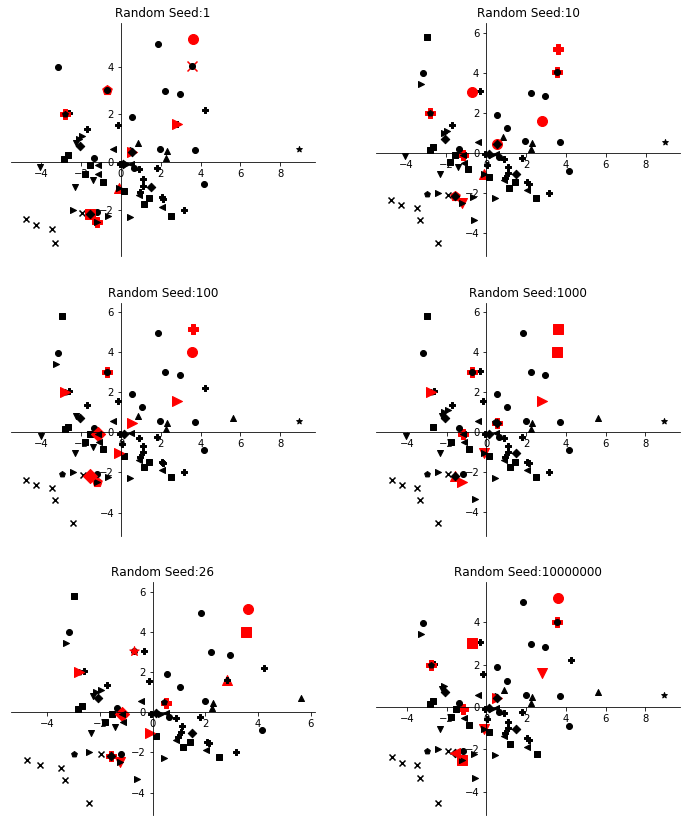

In [25]:
from lhs_comparison import multiple_lhs_designs
seeds=[1, 10, 100, 1000, 26, 10000000]
fig = plt.figure(figsize=(12, 30))
multiple_lhs_designs(domain, solvent_ds_full,solvent_ds_final, seeds, fig)

So, QIV is not sampled at all in any of the designs. Let's try something different. 

## 3. Initial Design - PCA Space

The likely cause of our problem is that we are doing the design over lots of variables (19), and the variance in the input space is not perfectly aligned with that orientation. This is evidenced by the fact that we have 

In [61]:
#Calculate principal components
num_components = 2
pc = PCA(n_components=num_components)
pc.fit(solvent_ds_full.standardize())
pcs = pc.transform(solvent_ds_final.standardize())
print(f"{round(pc.explained_variance_ratio_.sum()*100)}% of variance is explained by {num_components} principal components")

51.0% of variance is explained by 2 principal components


In [62]:
#Create a new dataset with just the principal components
metadata_df = solvent_ds_final.loc[:, solvent_ds_final.metadata_columns]
pc_df = pd.DataFrame(pcs, columns = [f'PC_{i}' for i in range(num_components)], index=metadata_df.index)
pc_ds = DataSet.from_df(pc_df)
solvent_ds_pcs = pd.concat([metadata_df, pc_ds], axis=1)

In [63]:
domain_pcs = Domain()
domain_pcs += DescriptorsVariable(name='solvent',
                             description='solvent for the borrowing hydrogen reaction',
                             ds=solvent_ds_pcs)
domain_pcs

Name,Type,Description,Values
solvent,descriptors,solvent for the borrowing hydrogen reaction,80 examples of 2 descriptors


In [64]:
rs = np.random.RandomState(1) #seed the random number generator for a determinsitic result
lhs = LatinDesigner(domain_pcs, random_state=rs)
experiments = lhs.generate_experiments(10)
indices = experiments.get_indices('solvent')[:,0]
solvent_ds_final.iloc[indices, :][solvent_ds_final.metadata_columns]

,stenutz_name,cosmo_name,chemical_formula,solvent_class,solvent_name
cas_number,,,,,
111-70-6,heptanol,1-heptanol,C7H16O,Alcohol,1-Heptanol
109-86-4,2-methoxyethanol,2-methoxyethanol,C3H8O2,Alcohol,2-Methoxy ethanol
71-43-2,benzene,benzene,C6H6,Aromatic,Benzene
142-82-5,heptane,n-heptane,C7H16,Alkane,n-Heptane
123-91-1,dioxane,dioxane,C4H8O2,Ether,"1,2-Dioxane"
100-66-3,methoxybenzene,anisole,C7H8O,Ether,Anisole
100-66-3,methoxybenzene,anisole,C7H8O,Ether,Anisole
64-17-5,ethanol,ethanol,C2H6O,Alcohol,Ethanol
56-81-5,"1,2,3-propanetriol",glycerol,C3H8O3,Alcohol,Glycerol


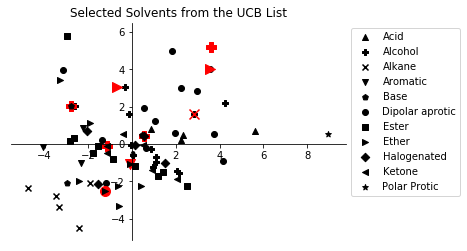

In [65]:
#Display by solvent class on a PCA plot

le = LabelEncoder() #Label encoder for the different solvent classes
solvent_classes = solvent_ds_pcs['solvent_class']
labels = le.fit_transform(solvent_classes)
fig, ax = plt.subplots()

markers = ['^', 'P', 'x', 'v', 'p', 'o', 's', '>', 'D', '<', '*']
for i, solvent_class in enumerate(le.classes_):
    ix = np.where(solvent_classes==solvent_class)[0]
    mask = np.ones(len(ix), dtype=bool)
    selects = []
    for j, select_idx in enumerate(indices):
        select = np.where(ix==select_idx)[0]
        ix = np.delete(ix, select)
        if len(select)> 0:
            selects.append(j)
    ax.scatter(pcs[ix, 0], pcs[ix, 1], c='k', marker=markers[i], label=solvent_class)
    if selects:
        ax.scatter(pcs[selects, 0], pcs[selects, 1], c='r', marker=markers[i], s=100)
        
#Plot formatting
ax.legend(bbox_to_anchor=(1, 1.0))
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
_ = ax.set_title('Selected Solvents from the UCB List')
plt.savefig('figures/full_descriptor_lhs.png')
plt.savefig('figures/full_descriptor_lhs.svg')